# BigBasket Product Data – Exploratory Data Analysis (EDA)


## Objective
The objective of this analysis is to examine BigBasket’s product assortment to identify category dominance, pricing segmentation, and discount behavior, and to assess whether these factors influence customer ratings. The insights are intended to support data-driven pricing and merchandising decisions.


## 1. Load Libraries & Dataset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
df = pd.read_csv('/content/drive/My Drive/Datasets/BigBasket_Products.csv')

## 2. Initial Data Inspection


In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27549 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18919 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


## 3. Data Cleaning


### 3.1 Remove Unnecessary Columns


In [ ]:
df = df.drop(columns=["index", "description"], errors="ignore")
df.index = range(1, len(df) + 1)

### 3.2 Correct Data Types


In [ ]:
# Blanks, texts and symbols may create problem late, so change them to NaN
df['sale_price']=pd.to_numeric(df['sale_price'],errors='coerce')
df['market_price']=pd.to_numeric(df['market_price'],errors='coerce')
df['rating']=pd.to_numeric(df['rating'],errors='coerce')

### 3.3 Check Missing Values


In [ ]:
df.isna().any()

,0
product,True
category,False
sub_category,False
brand,True
sale_price,True
market_price,False
type,False
rating,True


In [ ]:
print(df['sale_price'].isnull().sum())
print(df['market_price'].isnull().sum())
print(df['rating'].isnull().sum())

6
0
8636


### 3.4 Handle Missing Values


### Rationale for Handling Missing Values
Missing values in the `sale_price` column were handled by replacing them with `market_price`. This assumes that when a sale price is missing, the product is not discounted and is listed at its original market price.  
Missing values in `rating` were intentionally left unchanged, as not all products receive customer reviews.


In [ ]:
df["sale_price"] = df["sale_price"].fillna(df["market_price"])
# ratings left as NaN intentionally

### 3.5 Remove Duplicate Records


### Rationale for Duplicate Removal
Duplicate records were identified as rows where all columns contained identical values. Only such true duplicates were removed to avoid eliminating legitimate product variants that may share names or brands but differ in other attributes.


In [ ]:
df = df.drop_duplicates()

###Text stanrdadization

### Rationale for Text Standardization
Text fields such as category, sub-category, and brand were standardized to ensure consistency. This step prevents logically identical values with different casing or spacing from being treated as separate categories during analysis.


In [ ]:
for col in ['category','sub_category','brand']:
  df[col]=df[col].str.strip().str.title()

## 4. Feature Engineering


### Rationale for Feature Engineering
Discount-related features were created to enable analysis of pricing strategies. Discount amount and discount percentage help quantify how aggressively products are discounted across categories, while discount status provides a simple segmentation of discounted versus non-discounted products.


In [ ]:
# Creating new columns for eda
df["discount"] = df["market_price"] - df["sale_price"]
df['discount_%']=(df['discount']/df['market_price'])*100
df['discount_status']=np.where(
    df['discount']>0, "Discounted","Not_discounted"
)

## 5. Outlier & Anomaly Detection (Price Validation)


In [ ]:
# Rows where sale_price exceeds market_price
anomalies = df[df["sale_price"] > df["market_price"]]

anomalies.head()


,product,category,sub_category,brand,sale_price,market_price,type,rating,discount,discount_%,discount_status
249,4mm Aluminium Induction Base Chapati Roti Tawa...,"Kitchen, Garden & Pets",Cookware & Non Stick,Hazel,111649.0,1289.0,Tawa & Sauce Pan,NaN,-110360.0,-8561.675718,Not_discounted
289,Arrabbiata Tomato Pasta Sauce With Chilli,Gourmet & World Food,"Sauces, Spreads & Dips",Montanini,22325.0,325.0,Mustard & Cheese Sauces,5.0,-22000.0,-6769.230769,Not_discounted
413,Original Care Lip Balm For 24h Moisture With S...,Beauty & Hygiene,Skin Care,Nivea,1114.8,140.0,Lip Care,4.3,-974.8,-696.285714,Not_discounted
437,"Balloon - Polka Dot, 12 Inch",Cleaning & Household,Party & Festive Needs,B Vishal,88899.0,129.0,"Caps, Balloons & Candles",3.9,-88770.0,-68813.953488,Not_discounted
1250,Beard Kit,Beauty & Hygiene,Men'S Grooming,Uncle Tony,112475.0,3300.0,Combos & Gift Sets,NaN,-109175.0,-3308.333333,Not_discounted


Rows identified as pricing anomalies were removed from the dataset to ensure consistency in downstream analysis.


In [ ]:
# Remove logically invalid rows
df = df[df["sale_price"] <= df["market_price"]]
# Confirm anomalies are removed
df[df["sale_price"] > df["market_price"]]


,product,category,sub_category,brand,sale_price,market_price,type,rating,discount,discount_%,discount_status


## 6. Univariate Analysis

### 6.1 Market Price Distribution

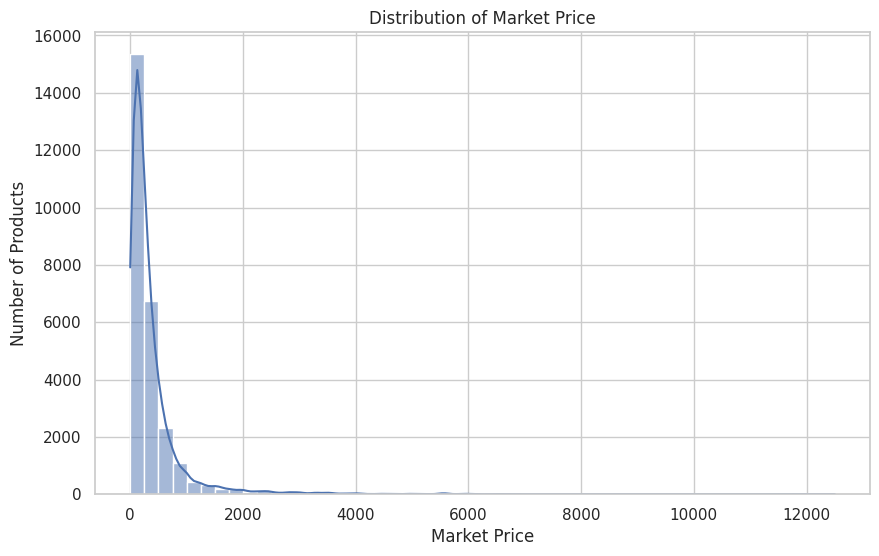

In [ ]:
sns.histplot(df["market_price"], bins=50, kde=True)
plt.title("Distribution of Market Price")
plt.xlabel("Market Price")
plt.ylabel("Number of Products")
plt.show()


### Interpretation
The distribution of market price is heavily right-skewed, indicating that most products are priced in the lower to mid range. A small number of high-priced products create a long tail, representing premium or specialty items. This pattern is typical in large retail catalogs and suggests a strong focus on affordability with limited premium offerings.


### 6.2 Rating Distribution

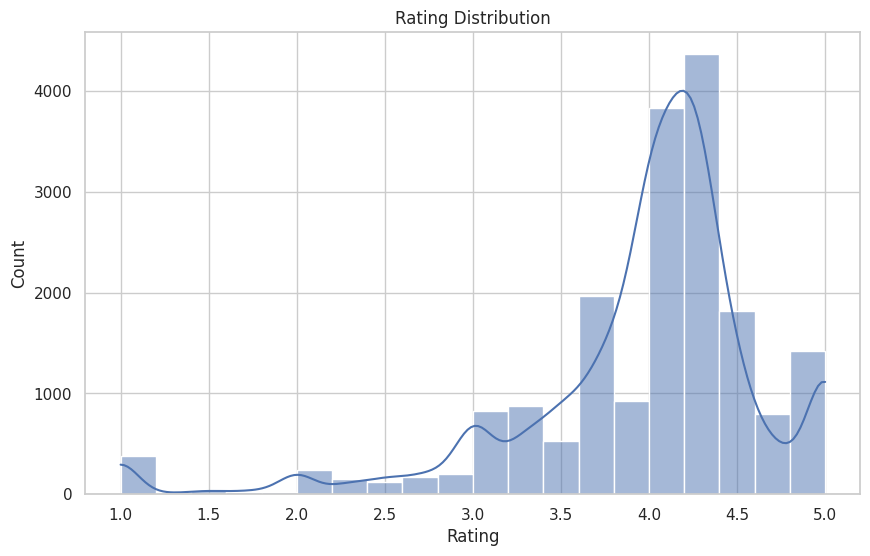

In [ ]:
sns.histplot(df["rating"],bins=20,kde=True)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### Interpretation
The rating distribution is concentrated between 3.5 and 4.5, indicating that most products receive positive customer feedback. Very low ratings are relatively rare, which may suggest effective quality control or lower visibility of poorly rated products. Ratings appear at discrete values, likely representing averaged or rounded customer scores rather than continuous measurements.


## 7. Categorical Analysis

### 7.1 Product Count by Category

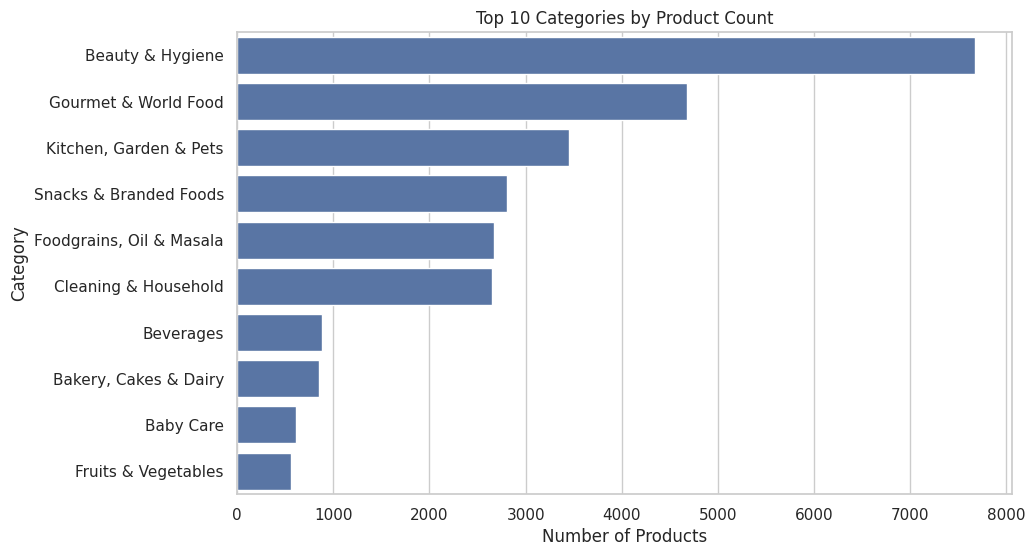

In [ ]:
top_categories = df["category"].value_counts().head(10)

sns.barplot(
    x=top_categories.values,
    y=top_categories.index
)
plt.title("Top 10 Categories by Product Count")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.show()


### Interpretation
The product catalog is highly concentrated in the Beauty & Hygiene category, which significantly outnumbers all other categories. This suggests intense competition and a wide variety of product offerings within this segment. Other categories such as Gourmet & World Food and Kitchen, Garden & Pets form a secondary tier, while categories like Baby Care and Fruits & Vegetables have comparatively fewer listings, indicating more specialized or inventory-driven product segments.


### 7.2 Product Count by Brand

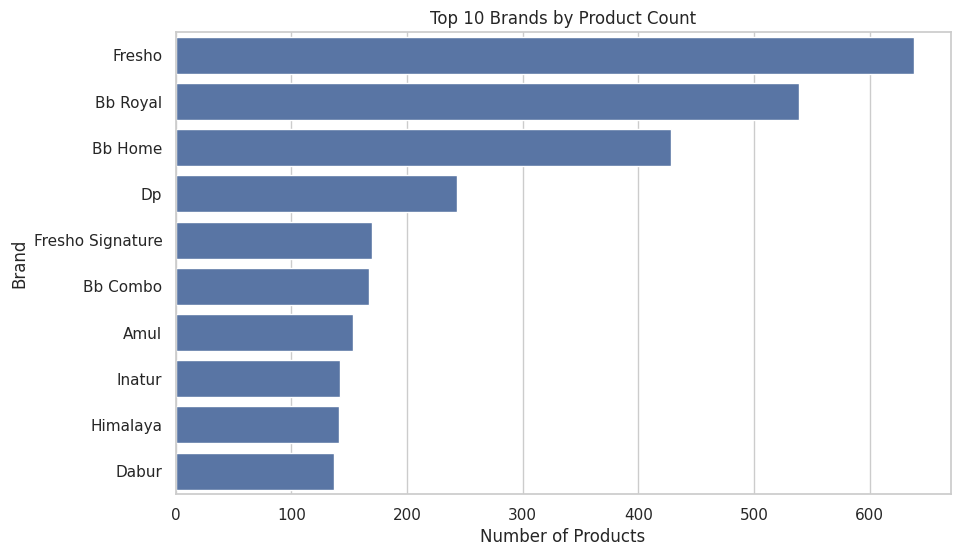

In [ ]:
top_brands = df["brand"].value_counts().head(10)

sns.barplot(
    x=top_brands.values,
    y=top_brands.index
)
plt.title("Top 10 Brands by Product Count")
plt.xlabel("Number of Products")
plt.ylabel("Brand")
plt.show()


### Interpretation
The product catalog is dominated by a small number of brands, particularly BigBasket’s private labels such as Fresho, BB Royal, and BB Home. This indicates a strong private-label strategy, where the platform offers a wide assortment of in-house products. Beyond the top brands, product counts drop sharply, forming a long tail of third-party brands that contribute fewer listings individually.


## 8. Bivariate Analysis

### 8.1 Average Sale Price by Category

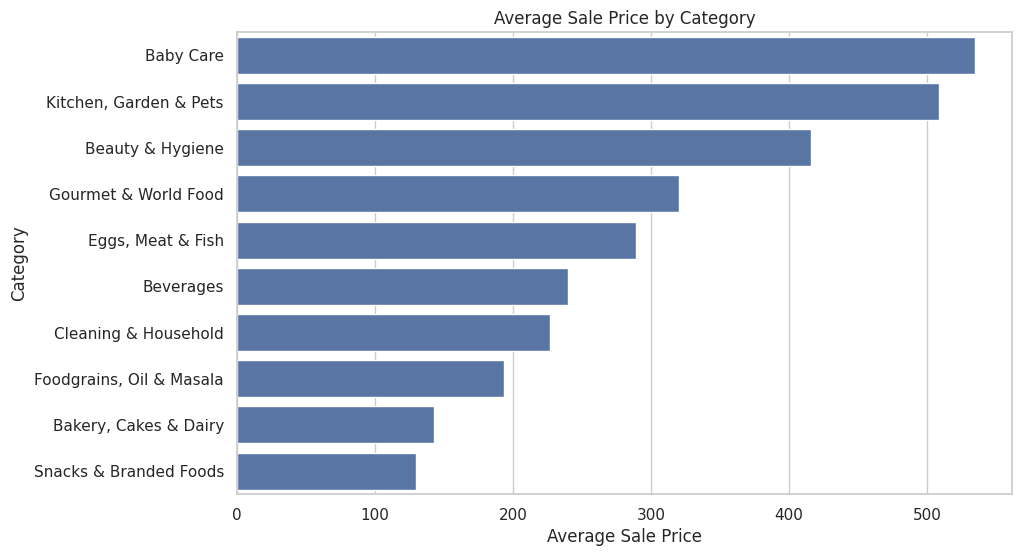

In [ ]:
avg_price_cat = (
    df.groupby("category")["sale_price"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

sns.barplot(
    x=avg_price_cat.values,
    y=avg_price_cat.index
)
plt.title("Average Sale Price by Category")
plt.xlabel("Average Sale Price")
plt.ylabel("Category")
plt.show()


### Interpretation
Average selling prices vary significantly across categories. Baby Care products have the highest average prices, indicating a premium positioning likely driven by quality and safety considerations. Categories such as Kitchen, Garden & Pets and Beauty & Hygiene also fall in the upper price range, while food-related categories like Snacks, Bakery, and Foodgrains are priced lower, reflecting high-frequency, price-sensitive purchasing behavior.


### 8.2 Average Discount by Category

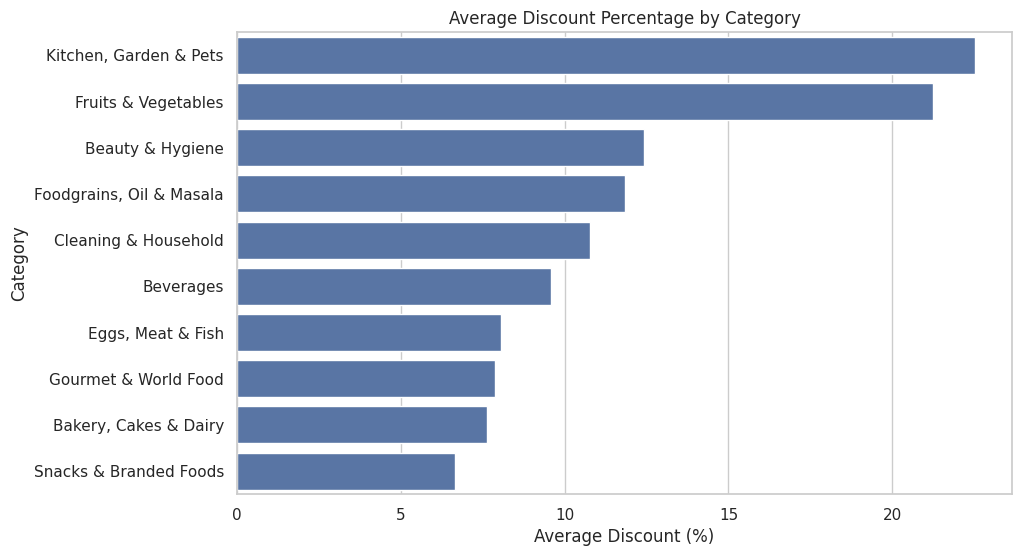

In [ ]:
avg_discount_cat = (
    df.groupby("category")["discount_%"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

sns.barplot(
    x=avg_discount_cat.values,
    y=avg_discount_cat.index
)
plt.title("Average Discount Percentage by Category")
plt.xlabel("Average Discount (%)")
plt.ylabel("Category")
plt.show()


### Interpretation
Average discount levels vary significantly across categories. Kitchen, Garden & Pets receives the highest average discounts, suggesting aggressive promotional strategies, possibly to stimulate demand or manage inventory. In contrast, categories such as Snacks, Bakery, and Gourmet & World Food show lower average discounts, indicating either tighter margins or stronger reliance on brand-driven demand rather than price-based promotions.


## 9. Discount Analysis

### 9.1 Discount Percentage Distribution (Exclude 0%)

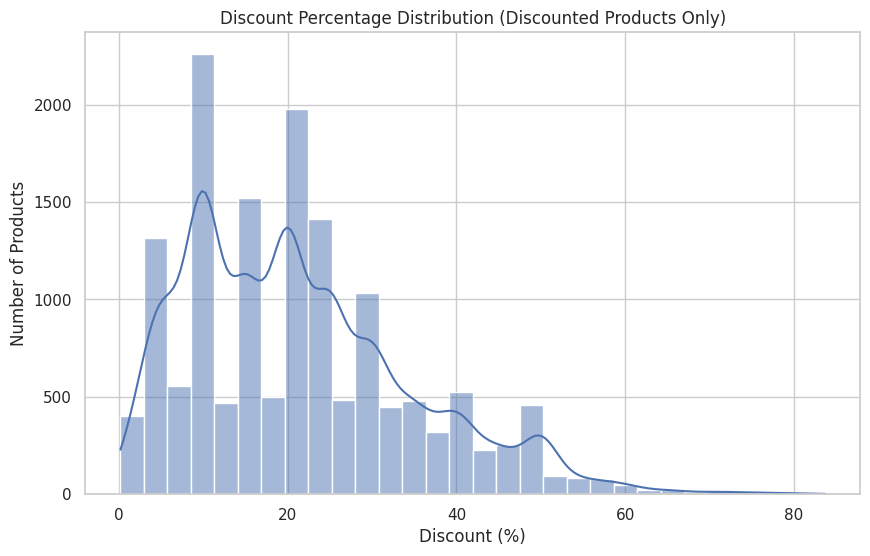

In [ ]:
discounted = df[df["discount_%"] > 0]

sns.histplot(discounted["discount_%"], bins=30, kde=True)
plt.title("Discount Percentage Distribution (Discounted Products Only)")
plt.xlabel("Discount (%)")
plt.ylabel("Number of Products")
plt.show()


### Interpretation
The discount percentage distribution is right-skewed, with most discounted products offering reductions between 5% and 25%. Deep discounts above 50% are relatively rare, indicating that promotions are applied selectively rather than as a blanket pricing strategy.


### 9.2 Discounted vs Non-Discounted Products

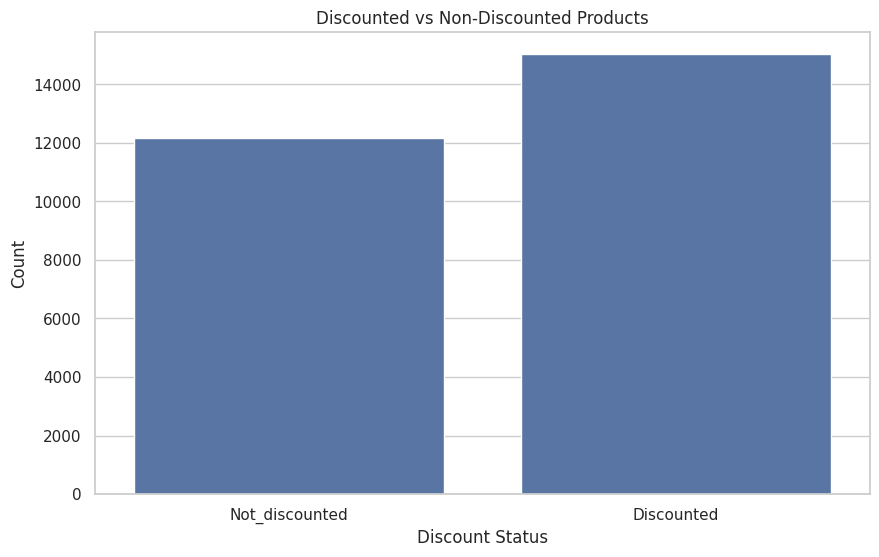

In [ ]:
sns.countplot(x=df["discount_status"])
plt.title("Discounted vs Non-Discounted Products")
plt.xlabel("Discount Status")
plt.ylabel("Count")
plt.show()


### Interpretation
A slightly larger share of products are offered at discounted prices compared to those sold at full price. This indicates that discounts are commonly used as part of the platform’s pricing strategy, while a significant portion of products continue to be sold without discounts, reflecting a balanced promotional approach.


## 10. Relationship Analysis

### 10.1 Relationship Between Sale Price and Customer Ratings

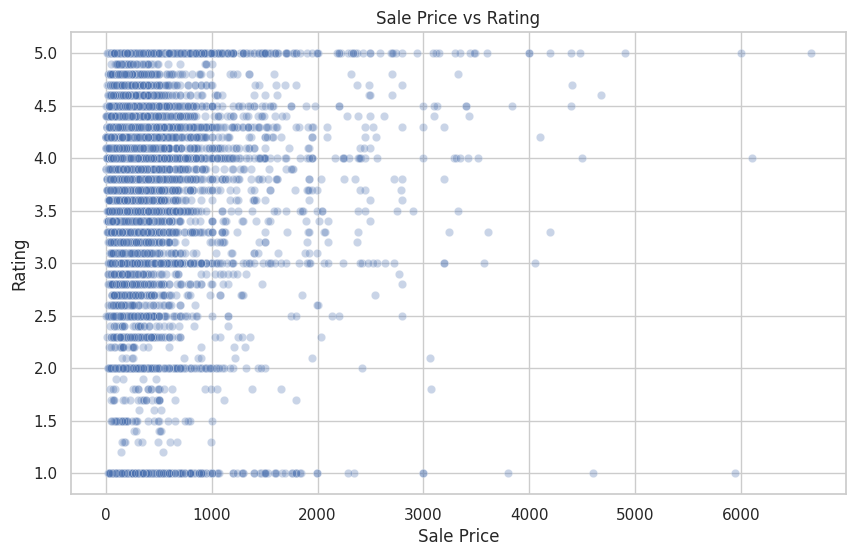

In [ ]:
sns.scatterplot(
    data=df,
    x="sale_price",
    y="rating",
    alpha=0.3
)
plt.title("Sale Price vs Rating")
plt.xlabel("Sale Price")
plt.ylabel("Rating")
plt.show()


### Interpretation
There is no strong relationship between sale price and product rating. Products across a wide range of prices receive similar ratings, suggesting that higher prices do not necessarily correspond to better customer satisfaction. Ratings are concentrated between 3.5 and 4.5 across all price levels, indicating generally positive feedback regardless of price.


### 10.2 Sale Price vs Discount %

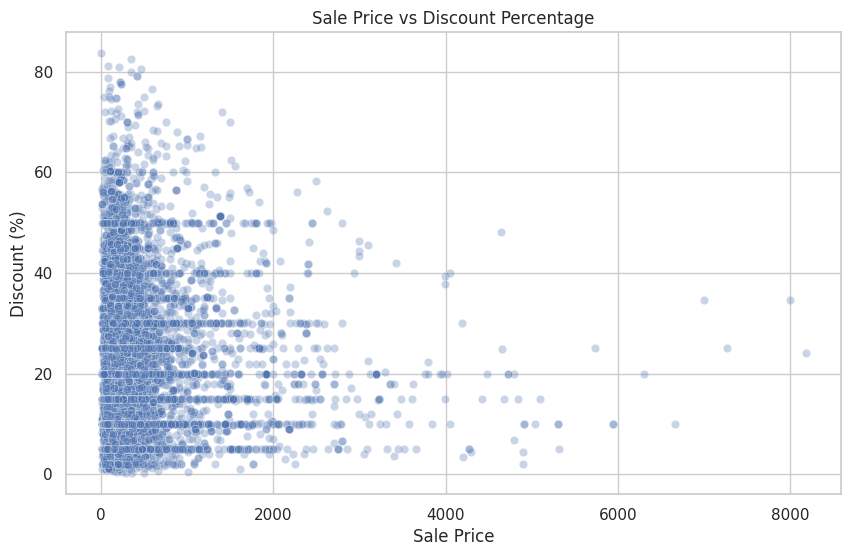

In [ ]:
sns.scatterplot(
    data=discounted,
    x="sale_price",
    y="discount_%",
    alpha=0.3
)
plt.title("Sale Price vs Discount Percentage")
plt.xlabel("Sale Price")
plt.ylabel("Discount (%)")
plt.show()


### Interpretation
Discount percentages are highest among low-priced products, with steep discounts concentrated below ₹1,000. As product prices increase, discount levels generally decrease, indicating that aggressive discounting is primarily used for mass-market items. High-priced products tend to receive smaller, more controlled discounts, likely to protect margins.


## 11. Multivariate Insight

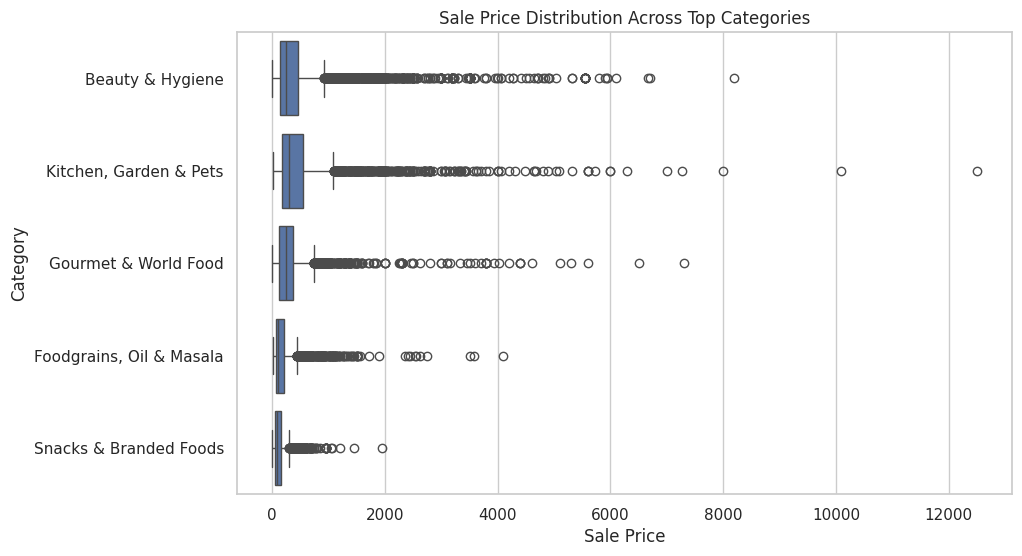

In [ ]:
top_cats = df["category"].value_counts().head(5).index

sns.boxplot(
    data=df[df["category"].isin(top_cats)],
    x="sale_price",
    y="category"
)
plt.title("Sale Price Distribution Across Top Categories")
plt.xlabel("Sale Price")
plt.ylabel("Category")
plt.show()


### Interpretation
All major categories exhibit right-skewed price distributions, with most products concentrated at lower price points and a small number of high-priced outliers. Kitchen, Garden & Pets shows the widest price variation, reflecting a diverse mix of products ranging from low-cost items to premium appliances. In contrast, Foodgrains and Snacks & Branded Foods have tighter price distributions, indicating more standardized pricing.


# Final EDA Summary

This exploratory analysis examined BigBasket’s product catalog to understand pricing behavior, discount strategies, category composition, brand dominance, and customer ratings.

The product catalog is heavily concentrated in a few major categories, with **Beauty & Hygiene**, **Gourmet & World Food**, and **Kitchen, Garden & Pets** accounting for a large share of listings. This indicates intense competition in these segments, particularly within personal care and packaged food categories.

Product prices across the platform are **highly right-skewed**, with most items priced in the low to mid range and a small number of premium products creating long price tails. Categories such as **Kitchen, Garden & Pets** exhibit the widest price variation due to a diverse mix of low-cost items and high-priced appliances, while **Foodgrains** and **Snacks & Branded Foods** show more standardized pricing.

Discounting is a common pricing strategy, with **discounted products slightly outnumbering non-discounted products**. However, most discounts fall within the **5%–25% range**, and steep discounts above **50%** are relatively rare. High discount percentages are primarily applied to **low-priced products**, while expensive products tend to receive smaller, controlled discounts to protect margins.

Category-level analysis shows that **Kitchen, Garden & Pets** and **Fruits & Vegetables** receive the highest average discounts, suggesting aggressive pricing strategies to drive volume or clear inventory. In contrast, staple food categories generally have lower discount levels.

Customer ratings are concentrated between **3.5 and 4.5** across nearly all price points. There is **no strong relationship between price and rating**, indicating that higher-priced products do not necessarily lead to higher customer satisfaction. Similarly, discount levels show no clear association with product ratings, suggesting that discounts do not directly influence perceived quality.

Overall, the analysis highlights that BigBasket’s pricing and discount strategies are **category-driven rather than uniform**, with clear distinctions between mass-market and premium segments. The insights derived from this EDA provide a strong foundation for deeper analysis involving sales volume, revenue, or customer behavior if transactional data becomes available.
